In [716]:
%matplotlib notebook

import sys, os
import segyio
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

from pathlib import Path

from torch import nn
import torch.nn.functional as F

In [717]:
# local modules loading 
module_path = str(Path.joinpath(Path(os.getcwd()).parent, Path("src") / "processing"))
sys.path.append(module_path)

from read_data import *
from process_horizons import *
from extract_info import *

In [718]:
data_path_root = str(Path.joinpath(Path(os.getcwd()).parent))
print(data_path_root)

fname = data_path_root + str( '/Seismic/seismic.sgy')
print(fname)

/app/NVGd Contest
/app/NVGd Contest/Seismic/seismic.sgy


In [719]:
geometry, data = read_segycube(fname,il_word=17,xl_word=25)

In [720]:
data.shape

(1423, 1073, 1501)

In [729]:
for d in geometry['m']:
    if d>2410:
        index_min, = np.where(geometry['m'] == d)
        print(index_min)
        break
istart = int(index_min)

[565]


In [730]:
for n in geometry['m']:
    if n>3980:
        index_max, = np.where(geometry['m'] == n)
        print(index_max)
        break
iend = int(index_max)

[826]


In [731]:
# limits in meters (according to Well logs and Mud Weight data)
#2410 - 3980 -> 565 - 826 in ms
data = data[:,:,istart:iend]

In [732]:
data.shape

(1423, 1073, 261)

In [713]:
#data = data/np.std(data)

<IPython.core.display.Javascript object>


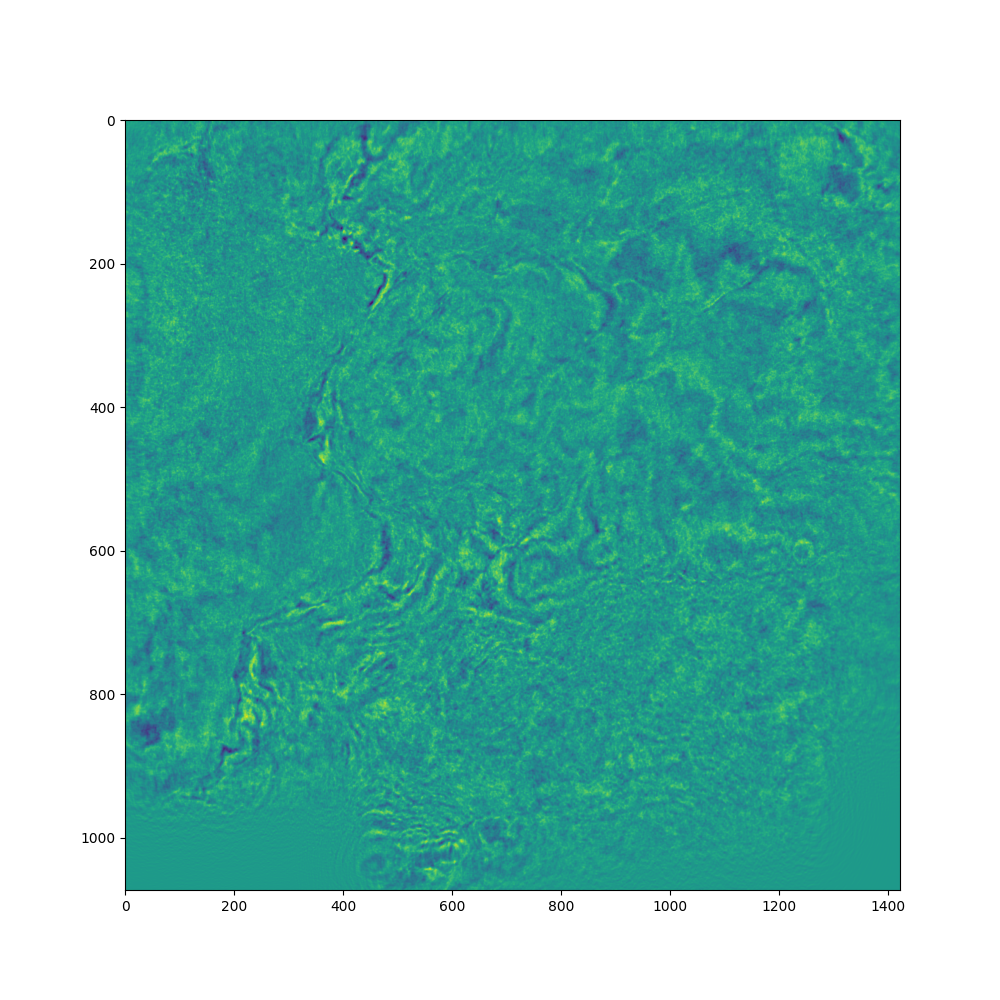

In [733]:
# plt.figure(figsize=(10,3))
# plt.imshow(data[500,:,:].T,aspect='auto')
# plt.show()

# plt.figure(figsize=(10,3))
# plt.imshow(data[:,500,:].T,aspect='auto')
# plt.show()

plt.figure(figsize=(10,10))
plt.imshow(data[:,:,250].T,aspect='auto')
plt.show()

In [734]:
mask_nonzero = np.invert(np.all(data==0,axis=-1))

In [735]:
data_select = data[mask_nonzero,:]

In [736]:
data_select.shape

(1526879, 261)

<IPython.core.display.Javascript object>


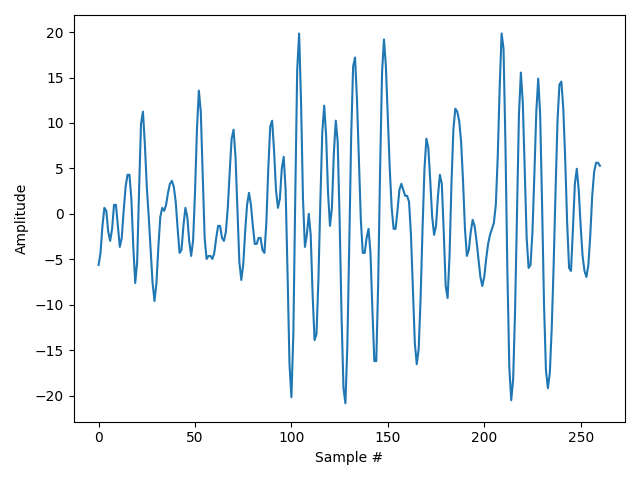

In [737]:
n_show = 89764

plt.figure()
plt.plot(data_select[n_show,:])
plt.xlabel('Sample #')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [738]:
geometry.keys()

dict_keys(['il', 'nil', 'xl', 'nxl', 'ntrace', 'mesh', 't', 'nt', 'dt', 'x', 'y', 'angle', 'direct', 'dxl_m', 'dil_m', 'm'])

In [739]:
geometry

{'il': array([2583, 2585, 2587, ..., 5423, 5425, 5427], dtype=int32),
 'nil': 1423,
 'xl': array([4616, 4618, 4620, ..., 6756, 6758, 6760], dtype=int32),
 'nxl': 1073,
 'ntrace': 1526879,
 'mesh': [array([[4616, 4618, 4620, ..., 6756, 6758, 6760],
         [4616, 4618, 4620, ..., 6756, 6758, 6760],
         [4616, 4618, 4620, ..., 6756, 6758, 6760],
         ...,
         [4616, 4618, 4620, ..., 6756, 6758, 6760],
         [4616, 4618, 4620, ..., 6756, 6758, 6760],
         [4616, 4618, 4620, ..., 6756, 6758, 6760]], dtype=int32),
  array([[2583, 2583, 2583, ..., 2583, 2583, 2583],
         [2585, 2585, 2585, ..., 2585, 2585, 2585],
         [2587, 2587, 2587, ..., 2587, 2587, 2587],
         ...,
         [5423, 5423, 5423, ..., 5423, 5423, 5423],
         [5425, 5425, 5425, ..., 5425, 5425, 5425],
         [5427, 5427, 5427, ..., 5427, 5427, 5427]], dtype=int32)],
 't': array([0.000e+00, 4.000e+00, 8.000e+00, ..., 5.992e+03, 5.996e+03,
        6.000e+03]),
 'nt': 1501,
 'dt': 4.0,
 '

In [740]:
m, n = geometry['mesh'][0].shape

In [741]:
geometry['x'].shape

(1423, 1073)

In [742]:
geometry['y'].shape

(1423, 1073)

In [743]:
X_x=[]
i=0
while i<n:
    X_x.append(515737.5+i*25)
    i+=1
X_x= np.asarray(X_x).reshape(1, n)

In [744]:
X_x

array([[515737.5, 515762.5, 515787.5, ..., 542487.5, 542512.5, 542537.5]])

In [745]:
X =(X_x).tolist()*m
X = np.reshape(X, (m, n))
X.shape

(1423, 1073)

In [746]:
m

1423

In [747]:
Y_y = []
y0 = 6821212.1
for i in range(m):
    Y_y.append([y0]*n)
    y0 = y0-25
    i+=1
Y = np.asarray(Y_y)
Y.shape

(1423, 1073)

In [748]:
geometry['x'] = X
geometry['x']

array([[515737.5, 515762.5, 515787.5, ..., 542487.5, 542512.5, 542537.5],
       [515737.5, 515762.5, 515787.5, ..., 542487.5, 542512.5, 542537.5],
       [515737.5, 515762.5, 515787.5, ..., 542487.5, 542512.5, 542537.5],
       ...,
       [515737.5, 515762.5, 515787.5, ..., 542487.5, 542512.5, 542537.5],
       [515737.5, 515762.5, 515787.5, ..., 542487.5, 542512.5, 542537.5],
       [515737.5, 515762.5, 515787.5, ..., 542487.5, 542512.5, 542537.5]])

In [749]:
geometry['y'] = Y
geometry['y']

array([[6821212.1, 6821212.1, 6821212.1, ..., 6821212.1, 6821212.1,
        6821212.1],
       [6821187.1, 6821187.1, 6821187.1, ..., 6821187.1, 6821187.1,
        6821187.1],
       [6821162.1, 6821162.1, 6821162.1, ..., 6821162.1, 6821162.1,
        6821162.1],
       ...,
       [6785712.1, 6785712.1, 6785712.1, ..., 6785712.1, 6785712.1,
        6785712.1],
       [6785687.1, 6785687.1, 6785687.1, ..., 6785687.1, 6785687.1,
        6785687.1],
       [6785662.1, 6785662.1, 6785662.1, ..., 6785662.1, 6785662.1,
        6785662.1]])

In [750]:
geometry

{'il': array([2583, 2585, 2587, ..., 5423, 5425, 5427], dtype=int32),
 'nil': 1423,
 'xl': array([4616, 4618, 4620, ..., 6756, 6758, 6760], dtype=int32),
 'nxl': 1073,
 'ntrace': 1526879,
 'mesh': [array([[4616, 4618, 4620, ..., 6756, 6758, 6760],
         [4616, 4618, 4620, ..., 6756, 6758, 6760],
         [4616, 4618, 4620, ..., 6756, 6758, 6760],
         ...,
         [4616, 4618, 4620, ..., 6756, 6758, 6760],
         [4616, 4618, 4620, ..., 6756, 6758, 6760],
         [4616, 4618, 4620, ..., 6756, 6758, 6760]], dtype=int32),
  array([[2583, 2583, 2583, ..., 2583, 2583, 2583],
         [2585, 2585, 2585, ..., 2585, 2585, 2585],
         [2587, 2587, 2587, ..., 2587, 2587, 2587],
         ...,
         [5423, 5423, 5423, ..., 5423, 5423, 5423],
         [5425, 5425, 5425, ..., 5425, 5425, 5425],
         [5427, 5427, 5427, ..., 5427, 5427, 5427]], dtype=int32)],
 't': array([0.000e+00, 4.000e+00, 8.000e+00, ..., 5.992e+03, 5.996e+03,
        6.000e+03]),
 'nt': 1501,
 'dt': 4.0,
 '

## Well data

In [751]:
#pip install openpyxl

In [752]:
wells_coords = data_path_root + str( '/Well Data/well_coords.xlsx')

wells = pd.read_excel(wells_coords)

In [753]:
wells

,well_name,X,Y
0,35/4-1,516075.50,6822412.01
1,35/8-1,519372.88,6802804.70
2,35/8-2,519635.98,6793184.26
3,35/8-3,528566.79,6802217.37


<IPython.core.display.Javascript object>


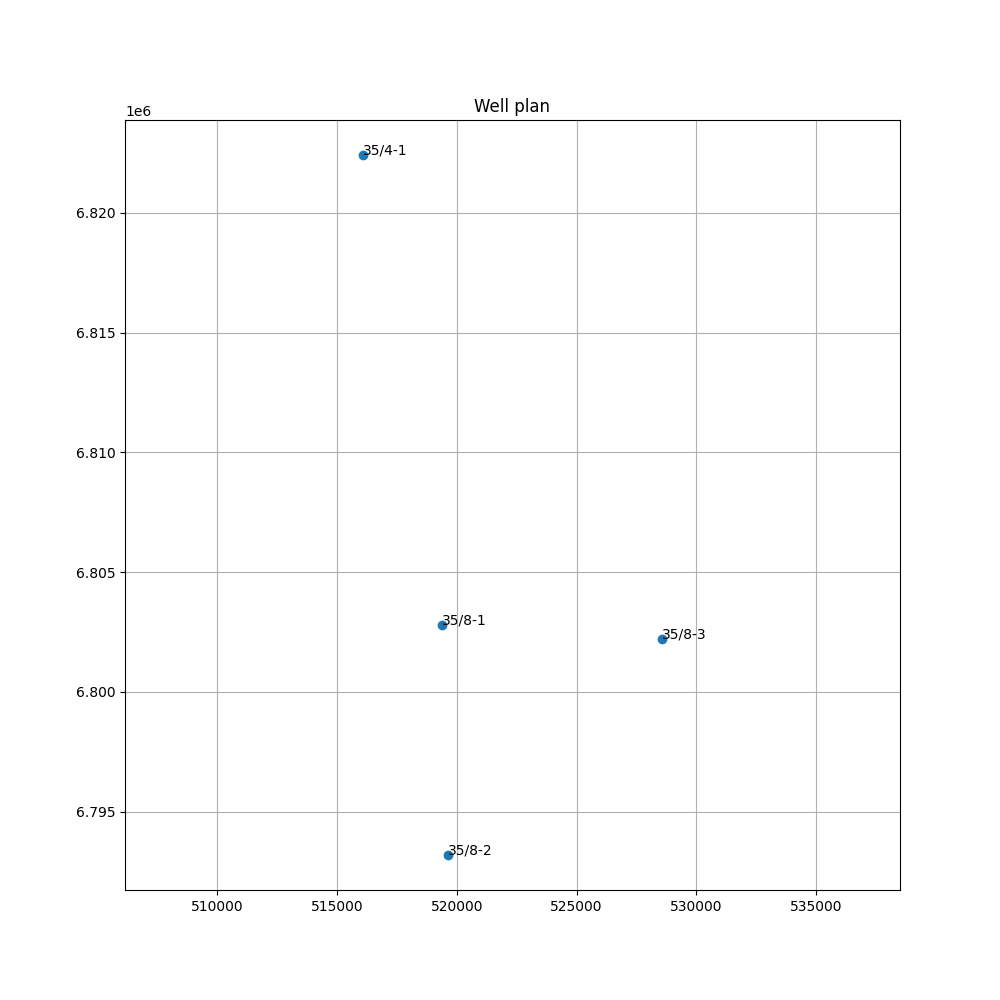

Text(0.5, 1.0, 'Well plan')

In [754]:
fig = plt.figure(figsize=(10,10))
ax = fig.subplots()
ax.scatter(x=wells['X'], y=wells['Y'], marker="o", linestyle='None')
text = wells['well_name']

for i, txt in enumerate(text):
    ax.annotate(txt, (wells['X'][i], wells['Y'][i]))
ax.axis('equal')
# ax.set_xlim(xmin = geometry['x'][0][0], xmax = geometry['x'][-1][-1])
# ax.set_ylim(geometry['y'][-1][-1], geometry['y'][0][0])
ax.grid(True)
ax.set_title('Well plan')

In [755]:
wells

,well_name,X,Y
0,35/4-1,516075.50,6822412.01
1,35/8-1,519372.88,6802804.70
2,35/8-2,519635.98,6793184.26
3,35/8-3,528566.79,6802217.37


In [756]:
data.shape

(1423, 1073, 261)

In [770]:
len(geometry['m'][istart:iend])

261

In [757]:
def get_nearest_trace(X, Y, data, geometry):
    delta = 25
    for x in geometry['x'][0]:
        if abs(x - X)<delta:
            delta = abs(x - X)
            indx = np.where(geometry['x'][0]==x)[0][0]
    delta=25
    g_y = []
    for i in range(len(geometry['y'])):
        g_y.append(geometry['y'][i][0])
    for y in g_y:
        if abs(y - Y)<delta:
            delta = abs(y - Y)
            indy = np.where(g_y==y)[0][0]
    return data[indy][indx]

In [768]:
trace_3582 = get_nearest_trace(519635.98, 6793184.26, data, geometry)
len(trace_3582)

261

In [759]:
def plot_trace(trace_data):
    plt.figure()
    plt.plot(trace_data)
    plt.xlabel('Sample #')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


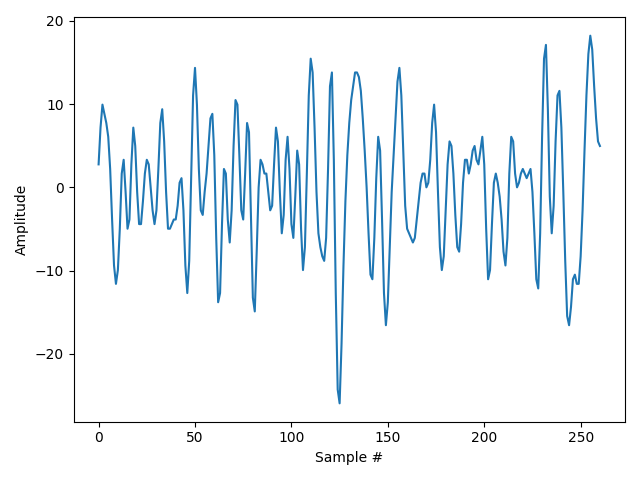

In [761]:
plot_trace(trace_3582)

In [954]:
def trace_to_df(trace, geometry, istart = 565, iend = 826):
    #print('Lenght of trace: ', len(trace))
    depth = geometry['m'][istart:iend].round()
    depth = [int(item) for item in depth]
    #print('Lenght of depth: ', len(depth))
    df = pd.DataFrame({'Depth':depth, 'Amplitude':trace})
    df = df.set_index('Depth')
    return df

In [955]:
imp_df = pd.read_excel(data_path+'35_8-2_impedance.xlsx')
imp_df = imp_df.dropna()
imp_df = imp_df[imp_df['Depth']>2400]
imp_df = imp_df.set_index('Depth')
imp_df

,Imp,PseudoImp,MW_int,Eatons PP,Imp_sm
Depth,,,,,
2401,5133.318090,265.063664,1.220,209627.049104,5105.862254
2406,5043.566278,254.449393,1.220,213430.781726,5103.560692
2411,5220.725758,261.636701,1.220,229782.556455,5126.253036
2416,5153.873555,257.155729,1.222,232561.388684,5138.094512
2421,5173.123506,254.747539,1.223,244488.648819,5144.921438
...,...,...,...,...,...
3956,6060.946350,174.216703,1.709,566201.756206,6124.438487
3961,6242.438274,180.293254,1.707,593634.956066,6159.885133
3966,6179.737914,184.343089,1.705,592761.992259,6144.859333


<IPython.core.display.Javascript object>


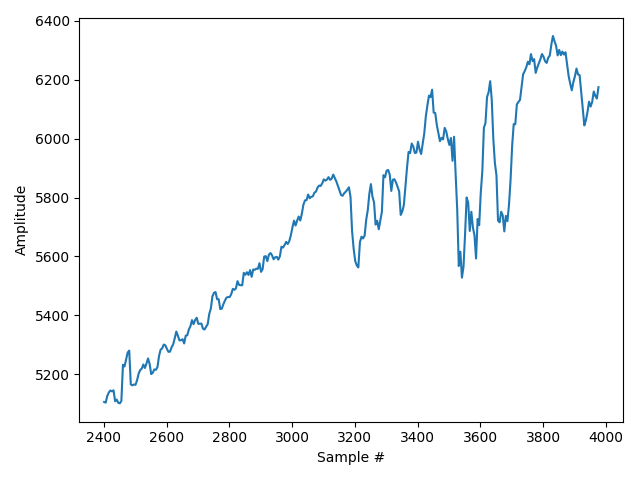

In [956]:
plot_trace(imp_df['Imp_sm'])

In [957]:
impedance_dd = imp_df['Imp_sm'].to_frame()
impedance_dd

,Imp_sm
Depth,
2401,5105.862254
2406,5103.560692
2411,5126.253036
2416,5138.094512
2421,5144.921438
...,...
3956,6124.438487
3961,6159.885133
3966,6144.859333


In [958]:
amplitude_dd = trace_to_df(trace_3582, geometry) #, istart = 565, iend = 828)
amplitude_dd

,Amplitude
Depth,
2412,2.759295
2418,7.174167
2423,9.933461
2429,8.829743
2434,7.726026
...,...
3949,16.555756
3955,12.140898
3961,8.277884


In [959]:
same_dd = impedance_dd.merge(amplitude_dd, left_on = impedance_dd.index, right_on = amplitude_dd.index, how = 'inner')
len(same_dd)

51

In [960]:
same_dd = same_dd.rename({'key_0': 'Depth'}, axis='columns')
same_dd = same_dd.set_index('Depth')
same_dd

,Imp_sm,Amplitude
Depth,,
2446,5103.238545,2.207436
2451,5101.215162,-3.863012
2491,5162.346732,-0.551859
2531,5221.224824,-4.414871
2571,5224.674365,-2.759295
2611,5276.826078,-0.551859
2651,5318.961973,0.551859
2686,5370.147037,1.103718
2721,5351.810652,-3.311153


In [961]:
trace = same_dd['Amplitude']
imped = same_dd['Imp_sm']

In [660]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter
import matplotlib.pyplot as plt
from scipy.signal import resample
from scipy.fft import rfft, rfftfreq

In [962]:
def fx_trace_calculation(trace):
    
    print('Начало рассчета FX-трассы')

    fx = [] # В fr складываем преобразованные трассы проходя по циклу ниже
    
    T = 0.004
    N = trace.shape[-1]

# Цикл преобразования трасс с перебором индексов инлайнов и кросслайнов #

    fx.append(np.abs(rfft(trace))) # Преобразование Фурье для каждой трассы 
            
    #for i in range(cube.shape[0]*cube.shape[1]):
        #fx[i] = fx[i]/fx[i].max()

    nx = rfftfreq(N, T)
    
    for i in range(len(nx)-1):
        nx[i] = round(nx[i], 2)

    fxr = np.array(fx) # Конвертируем список с FX трассами в массив
    fx_norm = fxr/fxr.max()
    fx_final = fx_norm
    
    rng_true_fx = nx
    rng_ind_fx = np.arange(0, len(nx))

    accord_fx = dict(zip(rng_true_fx, rng_ind_fx)) # Ставим в соответствие индексам значения Hz
    #accord_inv_fx = dict(zip(rng_ind_fx, rng_true_fx))
      
    print('Конец рассчета FX-трассы')

    return fx_final, nx, accord_fx

In [963]:
result, list_of_freq, accord_fx = fx_trace_calculation(trace)

Начало рассчета FX-трассы


KeyError: 'ALIGNED'

<IPython.core.display.Javascript object>


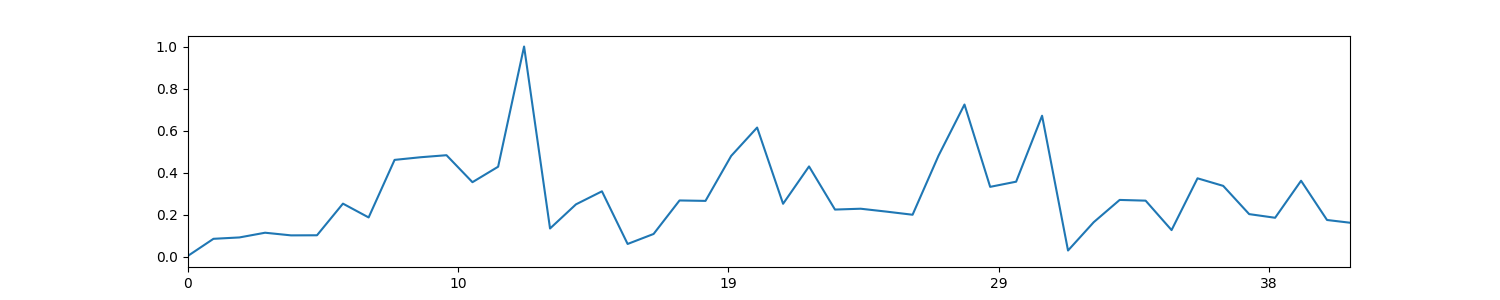

In [964]:
ffdim = result[0].shape[-1]

plt.figure(figsize=(15, 3))
plt.plot(list_of_freq, result[0])
plt.xticks(np.arange(0, ffdim, 10), ['%.0f' % s for s in list_of_freq[:ffdim][::10]])
plt.xlim(0, ffdim//3)
plt.show()

In [965]:
dt = 4

In [966]:
def ricker(f, l, dt):
    t = np.arange(-l/2, (1-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y

In [975]:
t, w = ricker(30, 0.128, dt/1000)

<IPython.core.display.Javascript object>


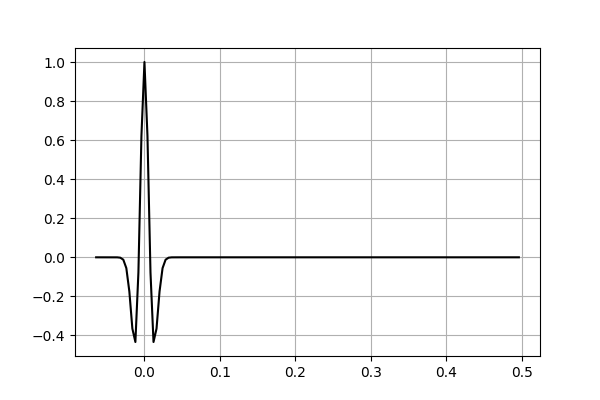

In [976]:
fig = plt.figure(figsize = (6,4))
ax1 = fig.add_subplot(111)
ax1.plot(t, w, color='black')
plt.grid(True)
plt.show()

In [977]:
synt_trace = signal.convolve(w, imped)

<IPython.core.display.Javascript object>


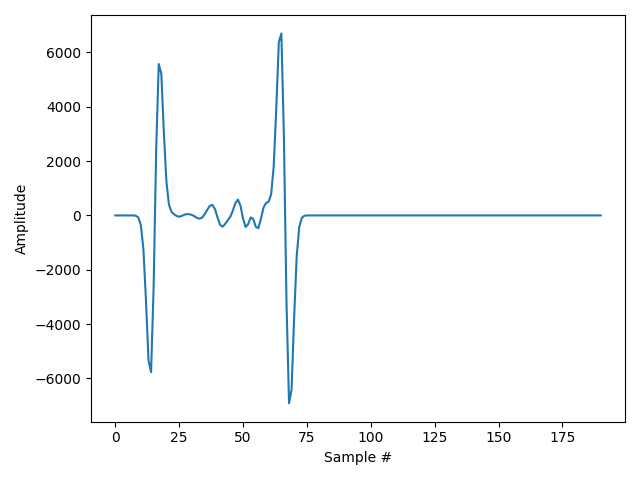

In [978]:
plot_trace(synt_trace)

<IPython.core.display.Javascript object>


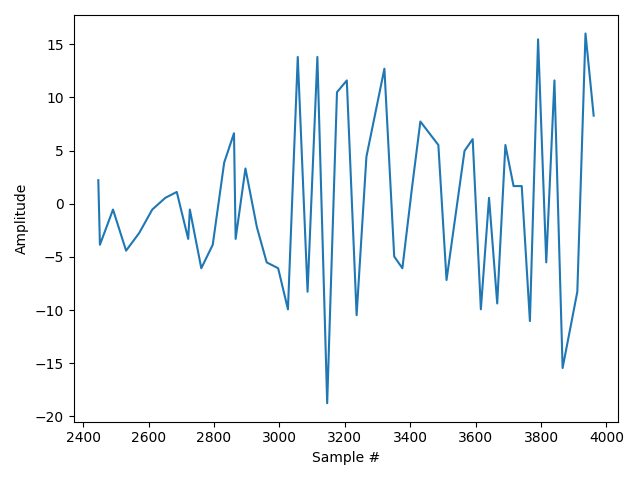

In [949]:
plot_trace(trace)

In [878]:
from scipy import signal
decon, rem = signal.deconvolve(signals, w)
#decon

In [884]:
decon, rem = signal.deconvolve(impulse_response, w)

<IPython.core.display.Javascript object>


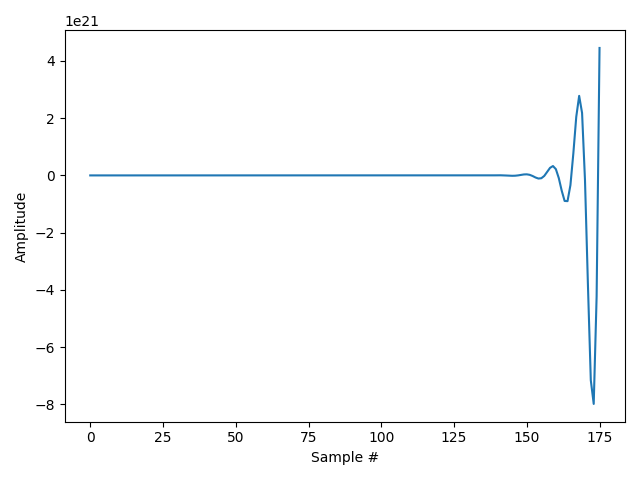

In [886]:
plot_trace(decon)

<IPython.core.display.Javascript object>


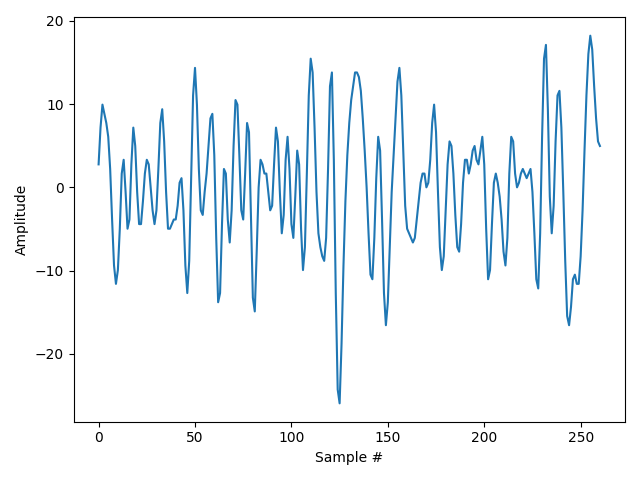

In [790]:
plot_trace(signals)

In [250]:
trace_3581 = get_nearest_trace(519372.88, 6802804.70, data, geometry)

<IPython.core.display.Javascript object>


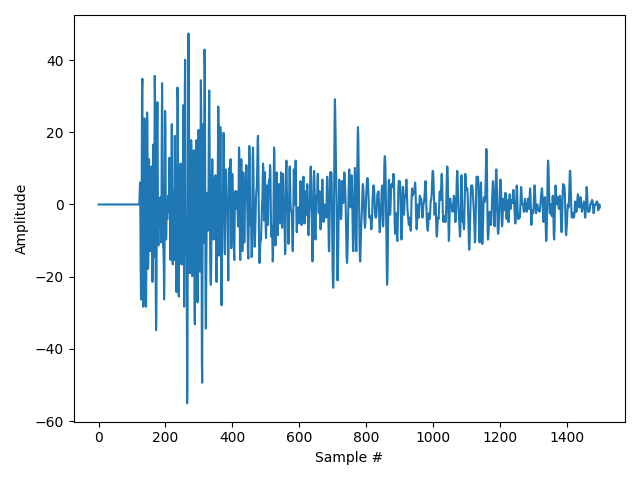

In [254]:
plot_trace(trace_3581)

In [251]:
trace_3583 = get_nearest_trace(528566.79, 6802217.37, data, geometry)

<IPython.core.display.Javascript object>


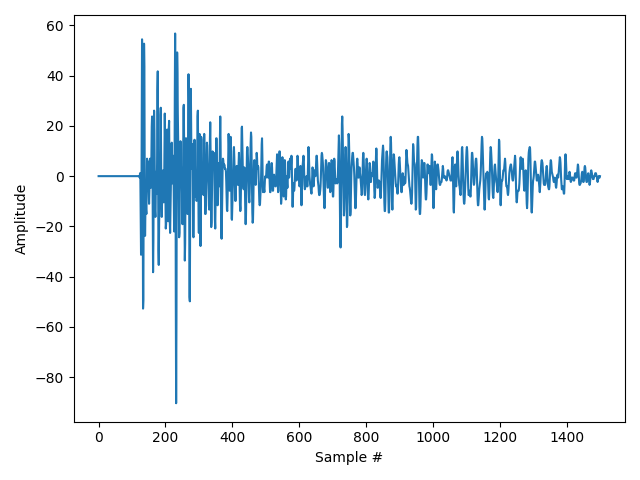

In [255]:
plot_trace(trace_3583)

## Velocity to Depth transformation

In [722]:
popt = [822.64241832, 1.31921726]

In [723]:
def vel_depth_law(x, a, b):
    return a*x**b

In [724]:
geometry['t'][1]

4.0

In [725]:
geometry['m'] = vel_depth_law(geometry['t']/1000, *popt)
len(geometry['m'])

1501

In [726]:
geometry['m'][1500]

8745.037172838018

In [727]:
geometry['m']

array([0.00000000e+00, 5.64686300e-01, 1.40906562e+00, ...,
       8.72965831e+03, 8.73734692e+03, 8.74503717e+03])

In [728]:
from pathlib import Path
parent_path = str(Path.joinpath(Path(os.getcwd()).parent))
data_path = parent_path + '/Data/'

In [323]:
trace_depth = pd.DataFrame()
trace_depth['Depth'] = geometry['m'].round(1)
trace_depth['Amp'] = trace_3581
trace_depth.set_index('Depth')
trace_depth.to_excel(data_path+'35_8-2.xlsx', engine = 'xlsxwriter')

In [315]:
trace_depth1 = pd.DataFrame()
trace_depth1['Depth'] = geometry['m'].round(1)
trace_depth1['Amp'] = trace_3581
trace_depth1.set_index('Depth')
trace_depth.to_excel(data_path+'35_8-1.xlsx', engine = 'xlsxwriter')

In [316]:
trace_depth3 = pd.DataFrame()
trace_depth3['Depth'] = geometry['m'].round(1)
trace_depth3['Amp'] = trace_3583
trace_depth3.set_index('Depth')
trace_depth.to_excel(data_path+geometry['m']'35_8-3.xlsx', engine = 'xlsxwriter')

In [302]:
#frames = [trace_depth1, trace_depth, trace_depth3]
#result = pd.concat(frames, ignore_index=True, sort=False)